In [1]:
import os
import cv2
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator


def histogram_equalization(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Merge the equalized channel with the original color channels
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = equalized
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    return img_output

def color_normalization(image):
    # Convert the image to floating-point format
    img_float = image.astype(float)

    # Normalize each channel to have zero mean and unit variance
    img_normalized = (img_float - np.mean(img_float, axis=(0, 1))) / np.std(img_float, axis=(0, 1))

    return img_normalized

def augment_image(image, augmenter):
    # Reshape the image to meet the input shape requirements of ImageDataGenerator
    image = np.expand_dims(image, 0)

    # Generate augmented images
    augmented_images = augmenter.flow(image, batch_size=1)

    # Get the first augmented image
    augmented_image = augmented_images.next()[0]

    return augmented_image

def load_and_preprocess_data(base_dir, image_size=(224, 224), test_size=0.2, random_state=42):
    X = []
    y = []

    # List the subdirectories in the training directory
    classes = os.listdir(os.path.join(base_dir, 'train'))

    # Create an ImageDataGenerator for augmentation
    augmenter = ImageDataGenerator(
        rotation_range=30,
        zoom_range=(0.8, 1.2),
        horizontal_flip=True,
        vertical_flip=True
        # Add more augmentation options as needed
    )

    for class_name in classes:
        class_path = os.path.join(base_dir, 'train', class_name)

        # Iterate over each file in the current class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                # Construct the full path to the image
                img_path = os.path.join(class_path, filename)

                try:
                    # Read the image using OpenCV
                    img = cv2.imread(img_path)

                    # Apply histogram equalization
                    img = histogram_equalization(img)

                    # Apply color normalization
                    img = color_normalization(img)

                    # Apply augmentation (only for training data)
                    if random.random() < 0.8:  # Adjust the probability based on your needs
                        img = augment_image(img, augmenter)

                    # Check if the image is not None (OpenCV couldn't read it)
                    if img is not None:
                        # Resize the image to a standard size
                        img = cv2.resize(img, image_size)

                        # Append the image to the X list
                        X.append(img)

                        # Append the label to the y list
                        # Here, the label is the index of the class in the 'classes' list
                        y.append(classes.index(class_name))
                    else:
                        print(f"Skipping unreadable image: {img_path}")

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Convert the labels to numerical values using LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Shuffle the data
    X, y = shuffle(X, y, random_state=random_state)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Return the training and testing data along with their labels, classes, and label encoder
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), classes, le

# Example usage:
base_dir = "C:/Food-101-minimized-main"
X_train, X_test, y_train, y_test, classes, label_encoder = load_and_preprocess_data(base_dir)


In [2]:
print(classes)

['cheesecake', 'cup_cakes', 'donuts', 'hamburger', 'pizza']


In [3]:
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

X_train shape (2800, 224, 224, 3)
X_test shape (700, 224, 224, 3)
y_train shape (2800,)
y_test shape (700,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


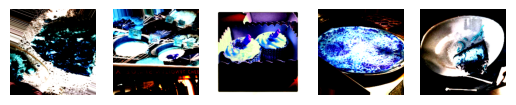

In [4]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')

plt.show()

In [5]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Function to extract SIFT features from an image
def extract_sift_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # You might want to use a fixed-size representation of the SIFT features,
    # for example, by aggregating them into a histogram or using a bag-of-words model.
    # Here, we'll use the mean of each descriptor as a representation.
    sift_features = np.mean(descriptors, axis=0) if descriptors is not None else np.array([])

    return sift_features

def load_data_with_sift(base_dir):
    X = []
    y = []

    # List the subdirectories in the training directory
    classes = os.listdir(os.path.join(base_dir, 'train'))

    for class_name in classes:
        class_path = os.path.join(base_dir, 'train', class_name)

        # Iterate over each file in the current class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg"):
                # Construct the full path to the image
                img_path = os.path.join(class_path, filename)

                # Read the image using OpenCV
                img = cv2.imread(img_path)

                # Resize the image to a standard size (e.g., 224x224)
                img = cv2.resize(img, (224, 224))

                # Extract SIFT features
                sift_features = extract_sift_features(img)
                
                # Append the SIFT features to the X list
                X.append(img)  # Append the original image, not just SIFT features

                # Append the label to the y list
                # Here, the label is the index of the class in the 'classes' list
                y.append(classes.index(class_name))

    # Convert the labels to numerical values using LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split the data into training and testing sets
    X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(X, y, test_size=0.2, random_state=42)

    # Return the training and testing data along with their labels and classes
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), classes


In [6]:
# Load data with SIFT features
X_train_sift, X_test_sift, y_train_sift, y_test_sift, classes_sift = load_data_with_sift(base_dir)

In [7]:
X_train_sift.shape

(2800, 224, 224, 3)

In [8]:
from sklearn.linear_model import LogisticRegression

# Reshape the X_train array
X_train_reshaped = X_train_sift.reshape(X_train_sift.shape[0], -1)

# Create a Logistic Regression model
logistic = LogisticRegression()

# Fit the model using the reshaped array
logistic.fit(X_train_reshaped, y_train_sift)


C:\Users\Menna\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
# Reshape the X_test array
X_test_reshaped = X_test_sift.reshape(X_test_sift.shape[0], -1)

# Calculate the accuracy score using the reshaped array
score = logistic.score(X_test_reshaped, y_test_sift)


In [10]:
score

0.23714285714285716

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Predict using the trained Logistic Regression model
predictions = logistic.predict(X_test_reshaped)
y_scores = logistic.predict_proba(X_test_reshaped)



In [12]:
predictions

array([1, 2, 2, 4, 4, 3, 1, 3, 3, 2, 1, 1, 2, 2, 0, 4, 2, 0, 1, 0, 2, 1,
       1, 3, 3, 1, 3, 0, 0, 0, 4, 1, 1, 1, 3, 4, 0, 4, 3, 3, 4, 2, 3, 2,
       4, 3, 4, 4, 2, 3, 3, 4, 4, 1, 0, 2, 3, 0, 3, 2, 3, 2, 2, 2, 3, 1,
       4, 2, 0, 0, 4, 3, 0, 1, 1, 0, 4, 2, 2, 3, 4, 2, 3, 4, 4, 4, 2, 2,
       3, 3, 0, 0, 4, 0, 2, 2, 1, 0, 0, 0, 3, 2, 2, 2, 3, 1, 4, 0, 4, 2,
       2, 3, 3, 3, 1, 2, 4, 4, 1, 3, 2, 3, 0, 1, 0, 3, 2, 1, 1, 3, 1, 1,
       4, 4, 1, 2, 0, 3, 0, 2, 1, 3, 3, 4, 3, 3, 0, 4, 2, 0, 2, 0, 0, 1,
       0, 1, 2, 4, 4, 0, 3, 0, 2, 3, 4, 4, 0, 4, 0, 1, 3, 0, 0, 2, 0, 1,
       3, 4, 0, 3, 0, 4, 0, 4, 0, 3, 2, 3, 3, 3, 1, 2, 3, 4, 4, 2, 0, 2,
       4, 3, 2, 3, 1, 2, 3, 3, 0, 2, 1, 1, 1, 0, 0, 4, 4, 0, 0, 0, 2, 0,
       3, 0, 1, 3, 1, 0, 4, 4, 1, 3, 4, 4, 0, 0, 4, 2, 1, 3, 1, 0, 1, 0,
       2, 2, 3, 1, 3, 4, 4, 3, 2, 4, 1, 0, 2, 2, 4, 2, 4, 3, 4, 0, 1, 2,
       0, 0, 1, 4, 0, 0, 3, 0, 1, 0, 2, 4, 3, 4, 4, 3, 0, 3, 2, 1, 3, 0,
       1, 2, 3, 2, 2, 2, 3, 1, 3, 1, 4, 0, 1, 0, 0,

In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test_sift, predictions)
classification_report_str = classification_report(y_test_sift, predictions)
conf_matrix = confusion_matrix(y_test_sift, predictions)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_str)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.23714285714285716
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.25      0.24       147
           1       0.24      0.23      0.23       133
           2       0.21      0.19      0.20       152
           3       0.24      0.31      0.27       122
           4       0.28      0.22      0.25       146

    accuracy                           0.24       700
   macro avg       0.24      0.24      0.24       700
weighted avg       0.24      0.24      0.24       700

Confusion Matrix:
[[37 27 29 32 22]
 [35 30 26 19 23]
 [31 24 29 42 26]
 [25 19 28 38 12]
 [32 26 26 30 32]]


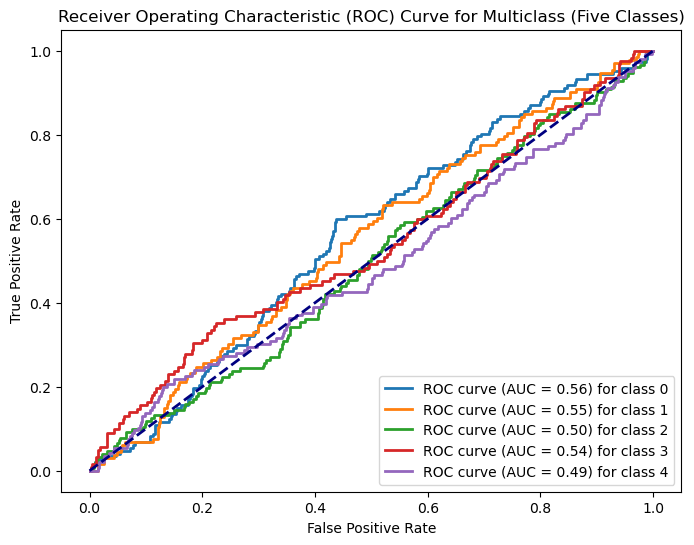

In [15]:
from sklearn.metrics import roc_curve, auc
# Initialize variables for ROC curve
n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test_sift == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass (Five Classes)')
plt.legend(loc='lower right')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


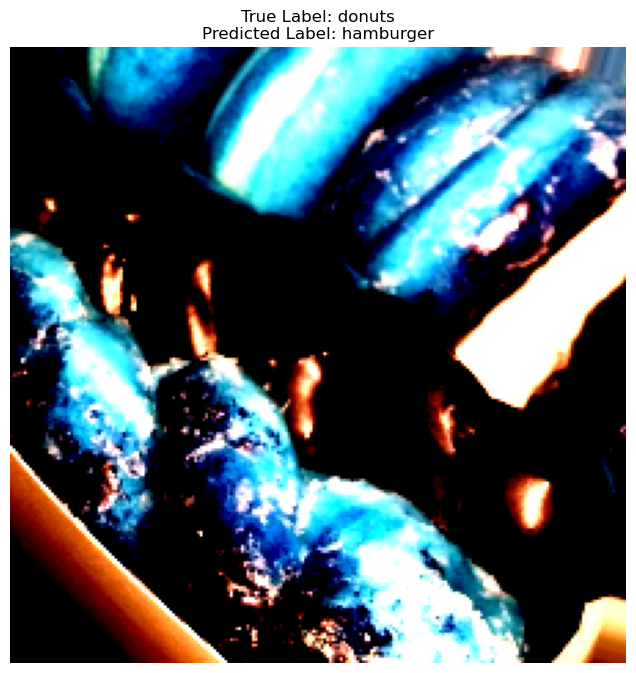

In [24]:
import matplotlib.pyplot as plt
import cv2
import random

def display_single_prediction(images, true_labels, predicted_labels, classes):

    # Select a random index from the dataset
    index = random.randint(0, len(images) - 1)

    # Get the image, true label, and predicted label
    image = images[index]
    true_label = true_labels[index]
    predicted_label = predicted_labels[index]

    # Display the original image with true and predicted labels
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)  # Use gray colormap for grayscale images
    plt.title(f'True Label: {classes[true_label]}\nPredicted Label: {classes[predicted_label]}')
    plt.axis('off')
    plt.show()

# Display one image with its true and predicted labels
display_single_prediction(X_test, y_test, predictions, classes)


In [17]:
import joblib
joblib.dump(logistic, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']